## Case 1: Inversion results of the Marmousi model using noise-free data


In [15]:
import time
import scipy.ndimage
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import deepwave
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%run utils.py
%run loss.py
%run plotting.py

In [3]:
# mar_smal, marm_big, over
dataname  = 'mar_smal'
sizestr   = '_100_310'

# Set parameters
peak_freq = 5.0
peak_source_time = 1 / peak_freq
dx = 30.0
dt = 0.003
nz = 100
ny = 310
nt = int(6 / dt)
num_dims = 2
num_shots = 30
num_sources_per_shot = 1
num_receivers_per_shot = ny
source_spacing = np.floor(dx * ny / (num_shots+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx * ny / (num_receivers_per_shot +1))
device = torch.device('cuda:0')
num_epochs = 250

## Filter frequencies below 3 Hz
use_filter = False
filter_type = 'highpass'
freqmin = 3                  # minimum frequency value for bandpass
freqmax = None           # maximum frequency value for bandpass
corners = 6                   # corners for filter
df = 1/dt

In [4]:
## save path
fwi_result = './result/' + dataname + sizestr + '_' + str(num_epochs) + 'epoch/'
if not os.path.exists(fwi_result):
    print(fwi_result)
    os.makedirs(fwi_result)

In [5]:
# # Create arrays containing the source and receiver locations
x_s, x_r = createSR(num_shots, num_sources_per_shot, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth=0,receiver_depth=0)
x_s, x_r = x_s.to(device), x_r.to(device)

In [6]:
## Load true model
vmodel_dim = np.array([nz, ny])
data_dir = 'data/'
data_path = data_dir + str(dataname) + str(sizestr) + '.bin'
model_true = loadtruemodel(data_path, num_dims, vmodel_dim).to(device)

In [7]:
print(model_true.shape)

torch.Size([100, 310])


In [8]:
### load or create initial source amplitude for inversion ###
source_amplitudes_true = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))
source_amplitudes = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq).reshape(-1, 1, 1))
source_amplitudes = torch.tensor(source_amplitudes).to(device)

C:\Users\dell\AppData\Local\Temp\ipykernel_20708\2986803287.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_amplitudes = torch.tensor(source_amplitudes).to(device)


In [9]:
### define the path and file name of noise-free rcv ###
rcvfile = fwi_result + str(dataname) + '_rcv_amps.mat'

prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_true = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

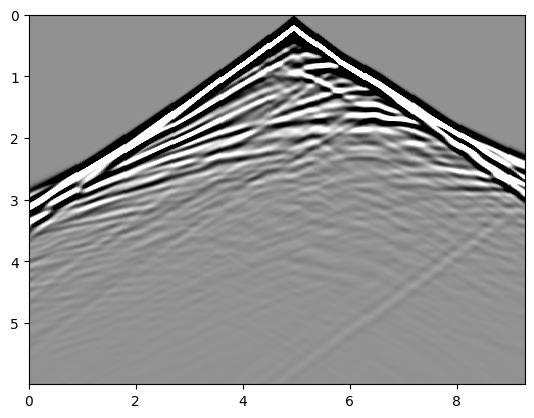

In [16]:
vmin, vmax = np.percentile(receiver_amplitudes_true[:,1].cpu().numpy(), [4,96])
plt.imshow(receiver_amplitudes_true[:,15].cpu().numpy(),extent=[0,(ny-1)*dx/1000,(nt-1)*dt,0], vmin=vmin, vmax=vmax,
           aspect='auto', cmap="gray")
plt.show()

In [17]:
# Create initial guess model for inversion by smoothing the true model
model_init = scipy.ndimage.gaussian_filter(model_true.cpu().detach().numpy(), sigma=15)
model_init = torch.tensor(model_init)

# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True
model = torch.nn.Parameter(model)

In [18]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params': model, 'lr': 2, 'betas':(0.9, 0.999), 'eps':1e-8, 'weight_decay':0}])

In [19]:
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0
TOL = 0.0
plot_ite = 300

num_batches = 10 # split data into 3 batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
vmin, vmax = np.percentile(model_true.cpu().detach().numpy(), [2,98]) # For plotting
model_loss = []

Epoch: 0 Loss:  834.6266784667969  model_loss:  230954.66
Epoch: 1 Loss:  797.7379455566406  model_loss:  233309.16
Epoch: 2 Loss:  765.9153594970703  model_loss:  235545.53
Epoch: 3 Loss:  733.8647232055664  model_loss:  237487.78
Epoch: 4 Loss:  701.0634536743164  model_loss:  238953.8
Epoch: 5 Loss:  667.3865814208984  model_loss:  239800.78
Epoch: 6 Loss:  632.5603904724121  model_loss:  239959.47
Epoch: 7 Loss:  596.7442474365234  model_loss:  239423.14
Epoch: 8 Loss:  560.2470855712891  model_loss:  238216.62
Epoch: 9 Loss:  525.3713760375977  model_loss:  236396.88
Epoch: 10 Loss:  493.6167449951172  model_loss:  234104.2
Epoch: 11 Loss:  462.85652923583984  model_loss:  231507.11
Epoch: 12 Loss:  432.156436920166  model_loss:  228719.9
Epoch: 13 Loss:  400.95278549194336  model_loss:  225796.86
Epoch: 14 Loss:  368.86585998535156  model_loss:  222759.84
Epoch: 15 Loss:  336.6444091796875  model_loss:  219618.73
Epoch: 16 Loss:  309.407621383667  model_loss:  216407.67
Epoch: 17

D:\Wang-Linrong\deepwave-0.0.9-gpu\plotting.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(2)
D:\Wang-Linrong\deepwave-0.0.9-gpu\plotting.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots()
D:\Wang-Linrong\deepwave-0.0.9-gpu\plotting.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

Epoch: 210 Loss:  83.2607147693634  model_loss:  78370.195


C:\Users\dell\AppData\Local\Temp\ipykernel_20708\1474445536.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


Epoch: 211 Loss:  99.21224069595337  model_loss:  78302.27
Epoch: 212 Loss:  91.71641373634338  model_loss:  78247.85
Epoch: 213 Loss:  81.78952836990356  model_loss:  78182.45
Epoch: 214 Loss:  91.96913528442383  model_loss:  78110.51
Epoch: 215 Loss:  96.6522262096405  model_loss:  78043.23
Epoch: 216 Loss:  88.87308073043823  model_loss:  77969.71
Epoch: 217 Loss:  84.95653915405273  model_loss:  77905.21
Epoch: 218 Loss:  97.22121620178223  model_loss:  77840.9
Epoch: 219 Loss:  98.74227905273438  model_loss:  77770.586
Epoch: 220 Loss:  82.40592050552368  model_loss:  77722.99
Epoch: 221 Loss:  89.15276074409485  model_loss:  77666.2
Epoch: 222 Loss:  102.1847083568573  model_loss:  77600.06
Epoch: 223 Loss:  87.12334966659546  model_loss:  77554.94
Epoch: 224 Loss:  82.96085262298584  model_loss:  77494.88
Epoch: 225 Loss:  99.49662971496582  model_loss:  77429.37
Epoch: 226 Loss:  95.57249975204468  model_loss:  77378.05
Epoch: 227 Loss:  84.97840452194214  model_loss:  77313.12

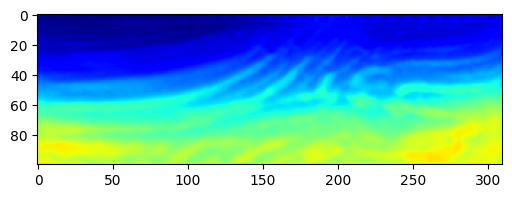

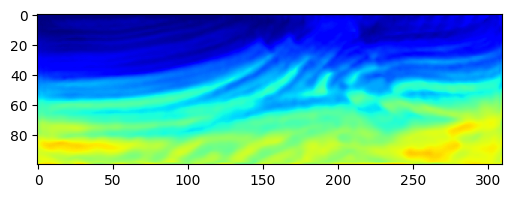

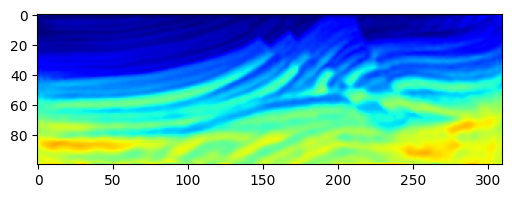

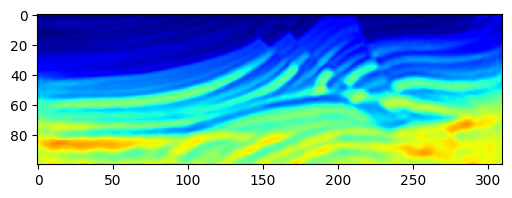

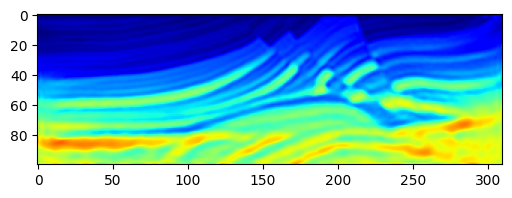

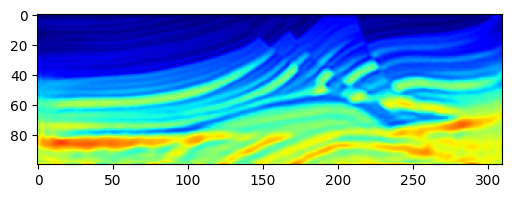

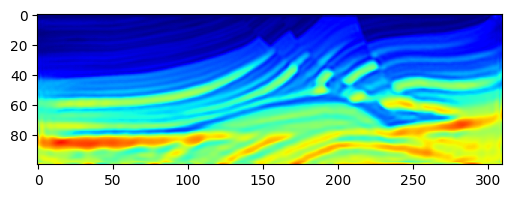

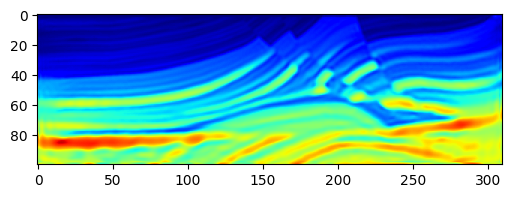

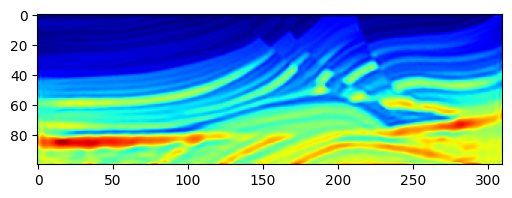

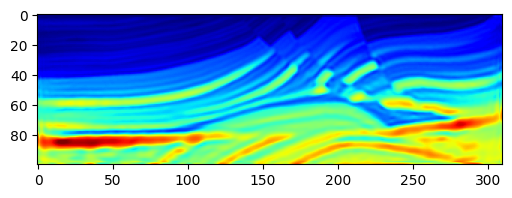

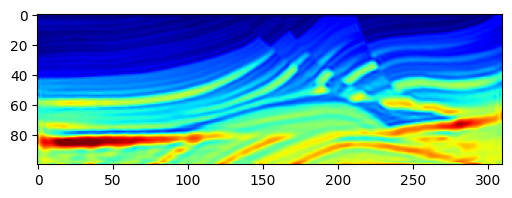

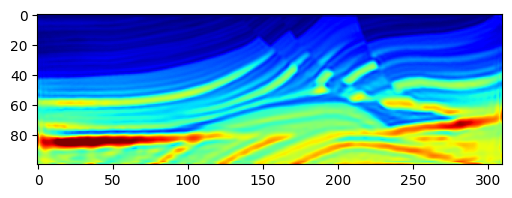

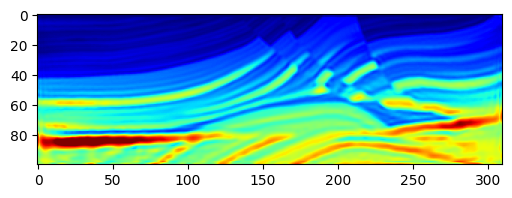

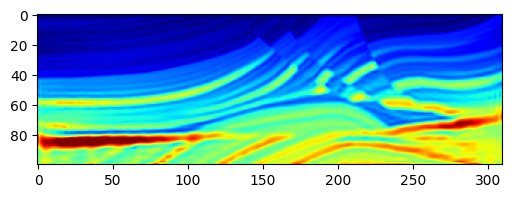

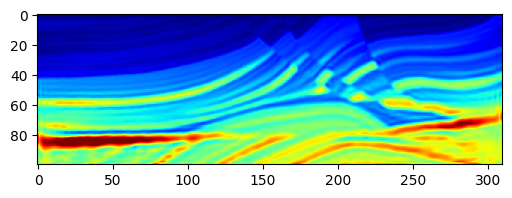

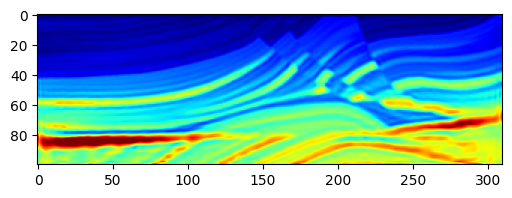

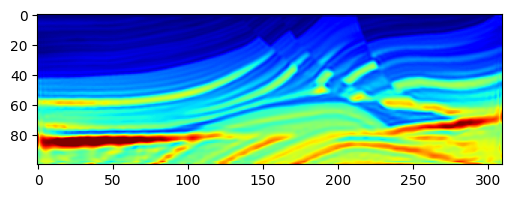

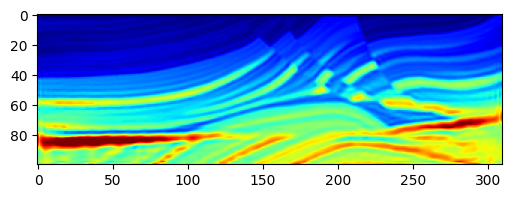

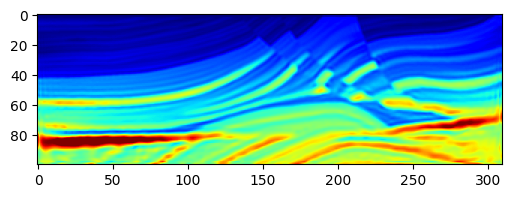

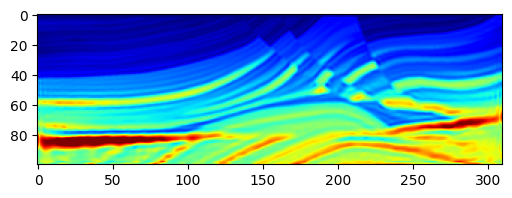

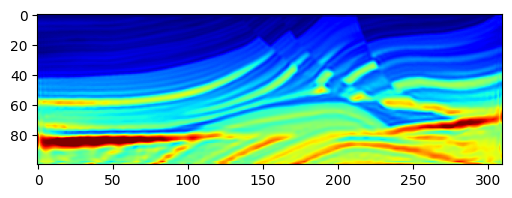

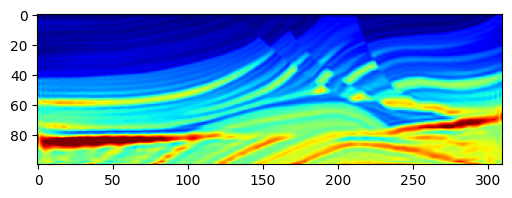

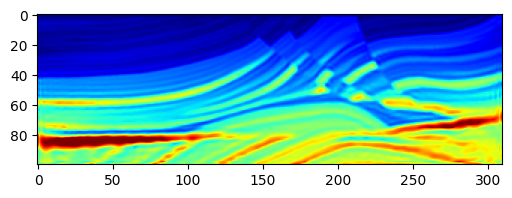

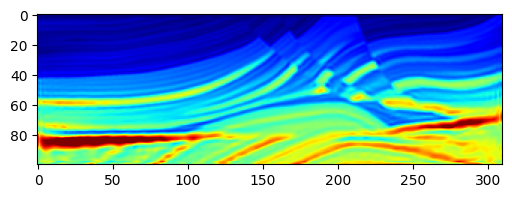

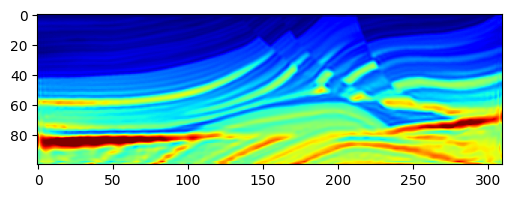

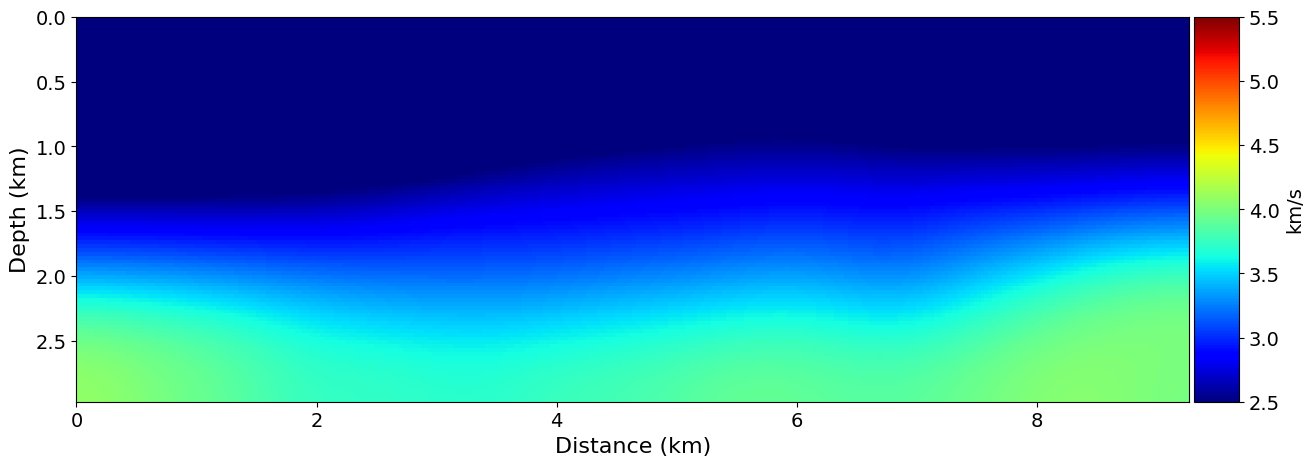

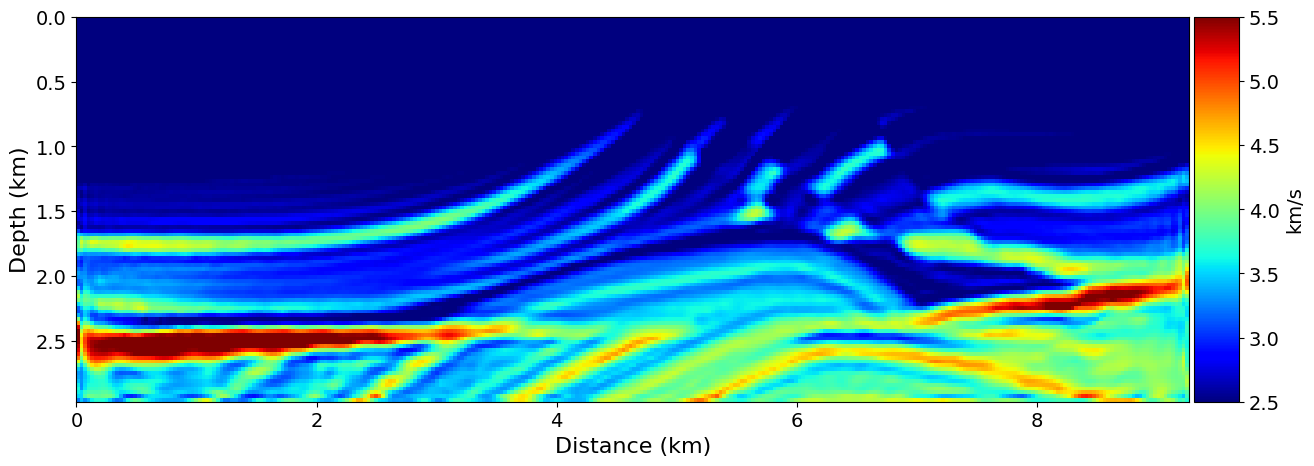

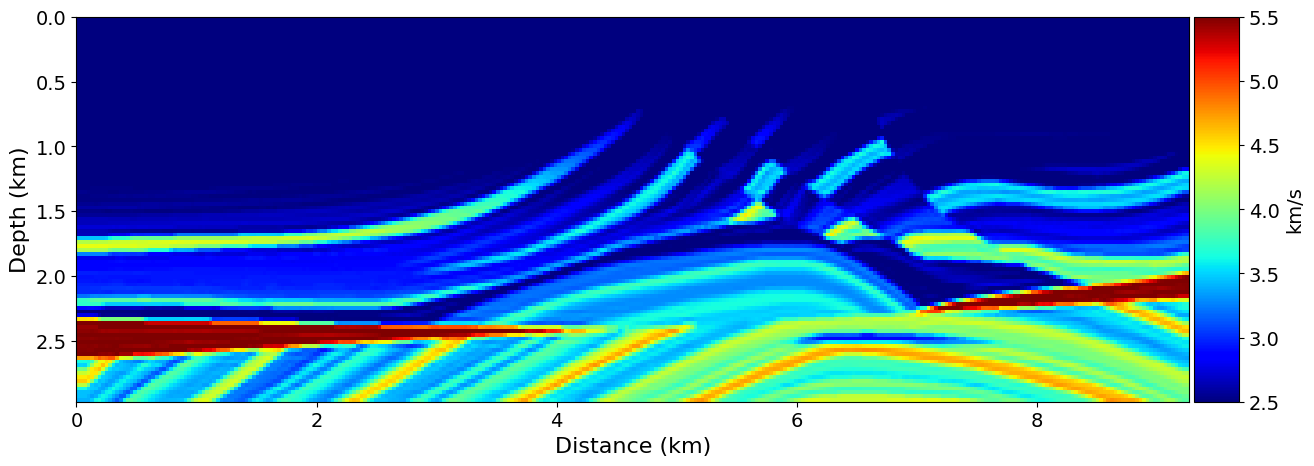

In [20]:
t_start = time.time()
for epoch in range(num_epochs):
  epoch_loss = 0.0
  start_time = time.time()
  for it in range(num_batches):
    optimizer.zero_grad()
    iteration = epoch * num_batches + it + 1
    prop = deepwave.scalar.Propagator({'vp': model}, dx)
    batch_src_amps = source_amplitudes.repeat(1, num_shots_per_batch, 1)
    batch_rcv_amps_true = receiver_amplitudes_true[:, it::num_batches].to(device)

    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)

    u_obs = batch_rcv_amps_true / torch.sqrt(torch.mul(batch_rcv_amps_true, batch_rcv_amps_true).sum())
    u_pred = batch_rcv_amps_pred / torch.sqrt(torch.mul(batch_rcv_amps_pred, batch_rcv_amps_pred).sum())

    loss_w = Wasserstein1(batch_rcv_amps_pred, batch_rcv_amps_true)
    loss_fft = FFT_loss(u_obs, u_pred)
    weight = 1.0 / (1.0 + np.exp(-(epoch - num_epochs // 2) / 10.0))
    loss = weight * loss_fft + (1.0 - weight) * loss_w

    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()

  end_time = time.time()

  v_loss = criterion(model.cpu(), model_true.cpu()).detach().numpy()
  model_loss.append(v_loss.item())
  print('Epoch:', epoch, 'Loss: ', epoch_loss,' model_loss: ', v_loss)

  if epoch !=0 and epoch % 10 == 0:
    plt.figure(figsize=(6, 4))
    plt.imshow(model.cpu().detach().numpy(), vmin=vmin, vmax=vmax,
               cmap='jet')
    plt.savefig(fwi_result +'/{}.png'.format(epoch))

  snr = ComputeSNR(model.detach().cpu().numpy(), model_true.detach().cpu().numpy())
  SNR = np.append(SNR, snr)

  ssim = ComputeSSIM(model.detach().cpu().numpy(), model_true.detach().cpu().numpy())
  SSIM = np.append(SSIM, ssim)

  rerror = ComputeRE(model.detach().cpu().numpy(), model_true.detach().cpu().numpy())
  ERROR = np.append(ERROR, rerror)
  #
  if iteration % plot_ite == 0:
    plotcomparison(gt=model_true.cpu().data.numpy(), \
                   pre=model.cpu().data.numpy(), \
                   ite=iteration, SaveFigPath=fwi_result)

    # plot SNR, ERROR, and SSIM
    PlotSNR(SNR=SNR, SaveFigPath=fwi_result)
    PlotSSIM(SSIM=SSIM, SaveFigPath=fwi_result)
    PlotERROR(ERROR=ERROR, SaveFigPath=fwi_result)


plt.figure(figsize=(6, 4))
plt.imshow(model.cpu().detach().numpy(), vmin=vmin, vmax=vmax,
           cmap='jet')
plt.savefig(fwi_result + '/latest.png')

t_end = time.time()
print('Runtime:', t_end - t_start)

model_loss = np.array(model_loss)
scipy.io.savemat(fwi_result + '/model_loss.mat', {'model_loss':model_loss/model_loss.max()})

# plot true velocity
plt.style.use('default')
plt.figure(figsize=(15, 5))
ax = plt.gca()
im = ax.imshow(model_init.numpy()/1000.0,extent=[0,(ny-1)*dx/1000,(nz-1)*dx/1000,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="jet")
plt.xlabel('Distance (km)', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(2.5,5.5)
cbar.set_label('km/s',size=14)
cbar.ax.tick_params(labelsize=14)
scipy.io.savemat(fwi_result + '/model_init.mat',{'model_init':model_init.numpy()})

# plot inverted velocity
plt.style.use('default')
plt.figure(figsize=(15, 5))
ax = plt.gca()
im = ax.imshow(model.cpu().detach().numpy()/1000.0,extent=[0,(ny-1)*dx/1000,(nz-1)*dx/1000,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="jet")
plt.xlabel('Distance (km)', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(2.5,5.5)
cbar.set_label('km/s',size=14)
cbar.ax.tick_params(labelsize=14)
scipy.io.savemat(fwi_result + '/model_inv.mat',{'model_inv':model.cpu().detach().numpy()})

# plot true velocity
plt.style.use('default')
plt.figure(figsize=(15, 5))
ax = plt.gca()
im = ax.imshow(model_true.cpu().detach().numpy()/1000.0,extent=[0,(ny-1)*dx/1000,(nz-1)*dx/1000,0], aspect='auto',
           vmin=vmin, vmax=vmax, cmap="jet")
plt.xlabel('Distance (km)', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(2.5,5.5)
cbar.set_label('km/s',size=14)
cbar.ax.tick_params(labelsize=14)
scipy.io.savemat(fwi_result + '/model_true.mat',{'model_true':model_true.cpu().detach().numpy()})


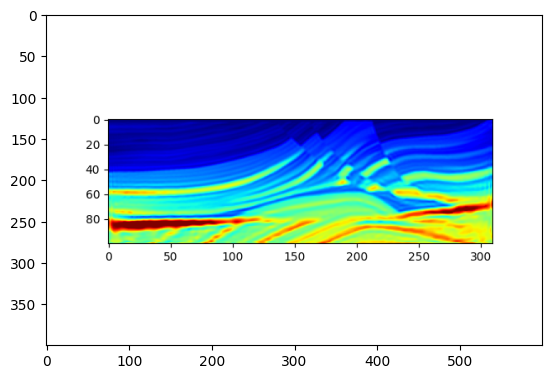

In [24]:
import cv2
img = cv2.imread("./result/mar_smal_100_310_250epoch/latest.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

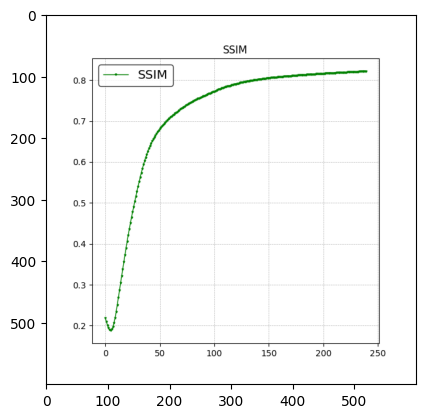

In [30]:
from PIL import Image
ssim = Image.open("./result/mar_smal_100_310_250epoch/SSIM.png")

plt.imshow(ssim)
plt.show()

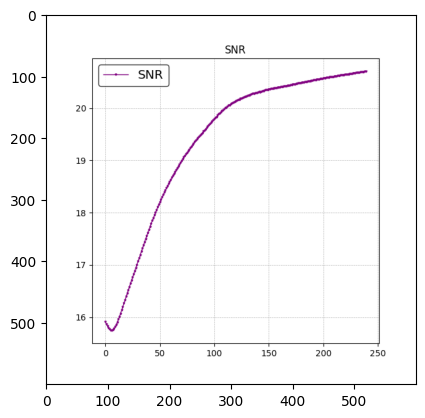

In [23]:
snr = Image.open("./result/mar_smal_100_310_250epoch/SNR.png")

plt.imshow(snr)
plt.show()

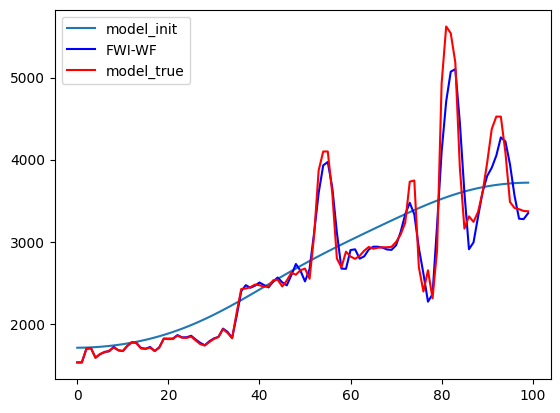

In [28]:
import scipy
model_inv = scipy.io.loadmat('./result/mar_smal_100_310_250epoch/model_inv')['model_inv']
model_true = scipy.io.loadmat('./result/mar_smal_100_310_250epoch/model_true')['model_true']
model_init = scipy.io.loadmat('./result/mar_smal_100_310_250epoch/model_init')['model_init']

i = 90  # x=2.7km
plt.plot(model_init[:, i], label='model_init')
plt.plot(model_inv[:, i], label='FWI-WF', color='b')
plt.plot(model_true[:, i], label='model_true', color='r')
plt.legend()
plt.show()


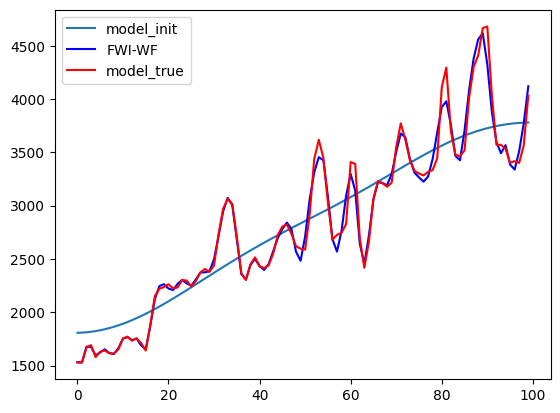

In [29]:
i = 145  # x=4.35km
plt.plot(model_init[:, i], label='model_init')
plt.plot(model_inv[:, i], label='FWI-WF', color='b')
plt.plot(model_true[:, i], label='model_true', color='r')
plt.legend()
plt.show()